In [204]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Facial Filters

Using your trained facial keypoint detector, you can now do things like add filters to a person's face, automatically. In this optional notebook, you can play around with adding sunglasses to detected face's in an image by using the keypoints detected around a person's eyes. Checkout the `images/` directory to see what pther .png's have been provided for you to try, too!

<img src="/content/images/face_filter_ex.png" width=60% height=60%/>

Let's start this process by looking at a sunglasses .png that we'll be working with!

In [205]:
# import necessary resources
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2

Image shape:  (1123, 3064, 4)


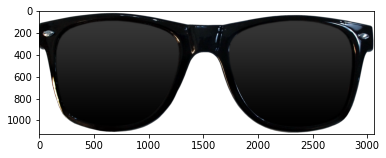

In [206]:
# load in sunglasses image with cv2 and IMREAD_UNCHANGED
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)

# plot our image
plt.imshow(sunglasses)

# print out its dimensions
print('Image shape: ', sunglasses.shape)

## The 4th dimension

You'll note that this image actually has *4 color channels*, not just 3 as your avg RGB image does. This is due to the flag we set `cv2.IMREAD_UNCHANGED`, which tells this to read in another color channel.

#### Alpha channel
It has the usual red, blue, and green channels any color image has, and the 4th channel respresents the **transparency level of each pixel** in the image; this is often called the **alpha** channel. Here's how the transparency channel works: the lower the value, the more transparent, or see-through, the pixel will become.  The lower bound (completely transparent) is zero here, so any pixels set to 0 will not be seen; these look like white background pixels in the image above, but they are actually totally transparent. 

This transparent channel allows us to place this rectangular image of sunglasses on an image of a face and still see the face area that is techically covered by the transparentbackground of the sunglasses image!

Let's check out the alpha channel of our sunglasses image in the next Python cell. Because many of the pixels in the background of the image have an alpha value of 0, we'll need to explicitly print out non-zero values if we want to see them.

The alpha channel looks like this (black pixels = transparent): 


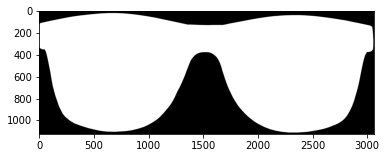

In [207]:
# print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]
print ('The alpha channel looks like this (black pixels = transparent): ')
plt.imshow(alpha_channel, cmap='gray')

In [208]:
# just to double check that there are indeed non-zero values
# let's find and print out every value greater than zero
values = np.where(alpha_channel != 0)
print ('The non-zero values of the alpha channel are: ')
print (values)

The non-zero values of the alpha channel are: 
(array([  17,   17,   17, ..., 1109, 1109, 1109]), array([ 687,  688,  689, ..., 2376, 2377, 2378]))


#### Overlaying images

This means that when we place this sunglasses image on top of another image, we can use the transparency channel as a filter:

* If the pixels are non-transparent (alpha_channel > 0), overlay them on the new image

#### Keypoint locations

In doing this, it's helpful to understand which keypoint belongs to the eyes, mouth, etc., so in the image below we also print the index of each facial keypoint directly on the image so you can tell which keypoints are for the eyes, eyebrows, etc.,

<img src="images/landmarks_numbered.jpg" width=50% height=50%/>

It may be useful to use keypoints that correspond to the edges of the face to define the width of the sunglasses, and the locations of the eyes to define the placement.

Next, we'll load in an example image. Below, you've been given an image and set of keypoints from the provided training set of data, but you can use your own CNN model to generate keypoints for *any* image of a face (as in Notebook 3) and go through the same overlay process!

In [209]:
# load in training data
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


In [210]:
# helper function to display keypoints
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')


Image name:  Christopher_Walken_01.jpg


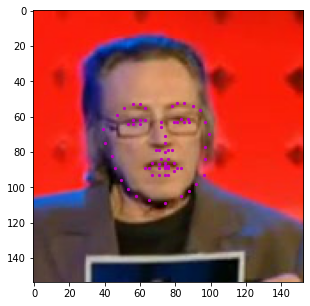

In [211]:
# a selected image
n = 120
image_name = key_pts_frame.iloc[n, 0]
image = mpimg.imread(os.path.join('data/training/', image_name))
key_pts = key_pts_frame.iloc[n, 1:].values.astype('float').reshape(-1, 2)

print('Image name: ', image_name)

plt.figure(figsize=(5, 5))
show_keypoints(image, key_pts)
plt.show()

Next, you'll see an example of placing sunglasses on the person in the loaded image.

Note that the keypoints are numbered off-by-one in the numbered image above, and so `key_pts[0,:]` corresponds to the first point (1) in the labelled image.

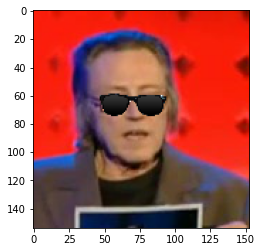

In [212]:
# Display sunglasses on top of the image in the appropriate place

# copy of the face image for overlay
image_copy = np.copy(image)

# top-left location for sunglasses to go
# 17 = edge of left eyebrow
x = int(key_pts[17, 0])
y = int(key_pts[17, 1])

# height and width of sunglasses
# h = length of nose
h = int(abs(key_pts[27,1] - key_pts[34,1]))
# w = left to right eyebrow edges
w = int(abs(key_pts[17,0] - key_pts[26,0]))

# read in sunglasses
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)
# resize sunglasses
new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

# get region of interest on the face to change
roi_color = image_copy[y:y+h,x:x+w]

# find all non-transparent pts
ind = np.argwhere(new_sunglasses[:,:,3] > 0)

# for each non-transparent point, replace the original image pixel with that of the new_sunglasses
for i in range(3): roi_color[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
# set the area of the image to the changed region with sunglasses
image_copy[y:y+h,x:x+w] = roi_color


# display the result!
plt.imshow(image_copy)

# Further steps

Look in the `images/` directory to see other available .png's for overlay! Also, you may notice that the overlay of the sunglasses is not entirely perfect; you're encouraged to play around with the scale of the width and height of the glasses and investigate how to perform [image rotation](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html) in OpenCV so as to match an overlay with any facial pose.

## Overlay perfect Filters

### Helper

In [213]:
# Using https://github.com/jrosebr1/imutils and https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/
# I saw that we can have a good idea of the angle to which display the filter by looking at the eyes

# compute the center of mass for each eye
def getAngleImage(shape):
    from collections import OrderedDict
    
    FACIAL_LANDMARKS_5_IDXS = OrderedDict([
      ("right_eye", (42, 47)),
      ("left_eye", (36, 41)),
      ("nose", (27, 35))
    ])
  
    (lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
    (rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]
    
    leftEyePts = shape[lStart:lEnd]
    rightEyePts = shape[rStart:rEnd]
    
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
    
    # compute the angle between the eye centroids
    dY = rightEyeCenter[1] - leftEyeCenter[1]
    dX = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dY, dX))

    return angle

# Choose image with tilted head to make sure angle is being calculated
n = 695
image_name = key_pts_frame.iloc[n, 0]
image = mpimg.imread(os.path.join('data/training/', image_name))
key_pts = key_pts_frame.iloc[n, 1:].values.astype('float').reshape(-1, 2)


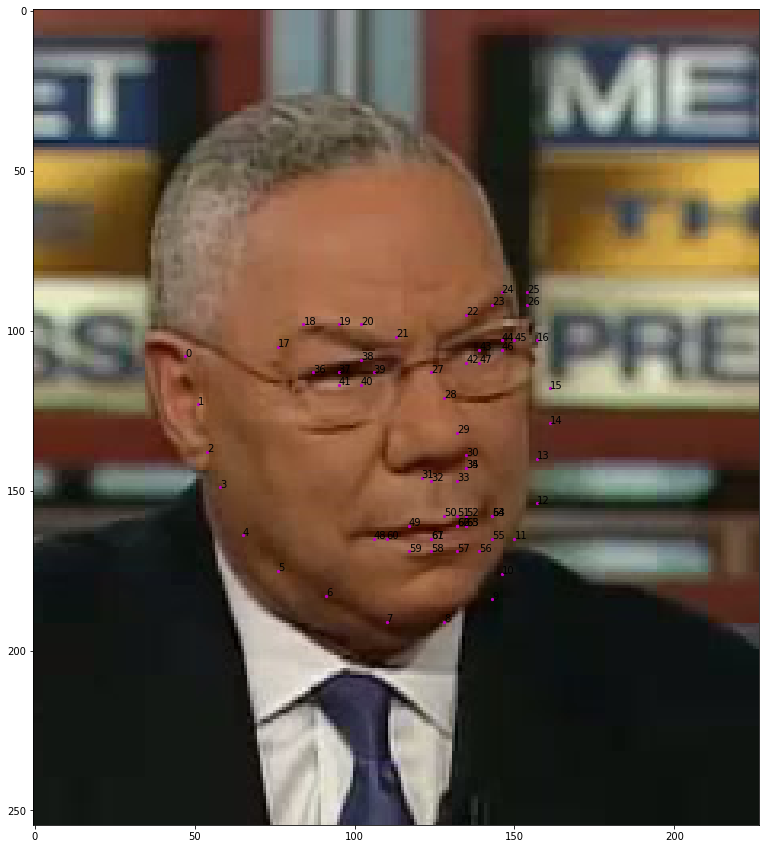

In [214]:
def plotFilterInImage(image, filterpath, x, y, h, w):
  image_copy = np.copy(image)

  filter = cv2.imread(filterpath, cv2.IMREAD_UNCHANGED)
  new_filter =  cv2.resize(filter, (w, h), interpolation = cv2.INTER_CUBIC)
  
  # Rotate picture according to angle of face
  angle = getAngleImage(key_pts)
  M = cv2.getRotationMatrix2D((w//2,h//2), -angle, 1)
  new_filter = cv2.warpAffine(new_filter, M, (w, h))

  roi_color = image_copy[y:y+h,x:x+w]
  ind = np.argwhere(new_filter[:,:,3] > 0)
  for i in range(3): roi_color[ind[:,0],ind[:,1],i] = new_filter[ind[:,0],ind[:,1],i]    

  image_copy[y:y+h,x:x+w] = roi_color
  plt.imshow(image_copy)

# helper function to display keypoints
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111)
    plt.imshow(image)
    ax.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')
    for i, (x,y) in enumerate(zip(key_pts[:, 0], key_pts[:, 1])):
      ax.annotate(i, (x, y))
    plt.show()

show_keypoints(image, key_pts)

### Sunglasses

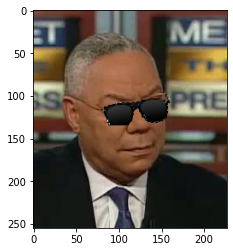

In [215]:
x_glasses, y_glasses = int(key_pts[17, 0]*1.1), int(key_pts[17, 1])
h_glasses, w_glasses = int(abs(key_pts[27,1] - key_pts[34,1])), int(abs(key_pts[17,0] - key_pts[26,0]))
plotFilterInImage(image, 'images/sunglasses.png', x_glasses, y_glasses, h_glasses, w_glasses)

### Mustache

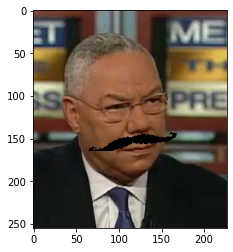

In [216]:
x_mustache, y_mustache = int(key_pts[4, 0]), int(key_pts[34, 1])
h_mustache, w_mustache = int(abs(key_pts[63,1] - key_pts[30,1])), int(abs(key_pts[3,0] - key_pts[14,0]))
plotFilterInImage(image, 'images/moustache.png', x_mustache, y_mustache, h_mustache, w_mustache)

### Hat

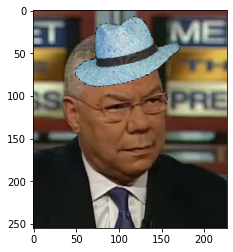

In [217]:
x_hat, y_hat = int(key_pts[0, 0] * 0.7), 0
h_hat, w_hat = int(min(key_pts[:,1])*1.1), int(abs(key_pts[0,0] - key_pts[16,0]) * 1.4)
plotFilterInImage(image, 'images/straw_hat.png', x_hat, y_hat, h_hat, w_hat)

## Curvature of Mouth

In [277]:
image = mpimg.imread(os.path.join('data/training/', image_name))
image.shape

(255, 227, 4)

[[149 130  68  34]
 [ 82 145  68  34]]
[149 130  68  34]
[ 82 145  68  34]


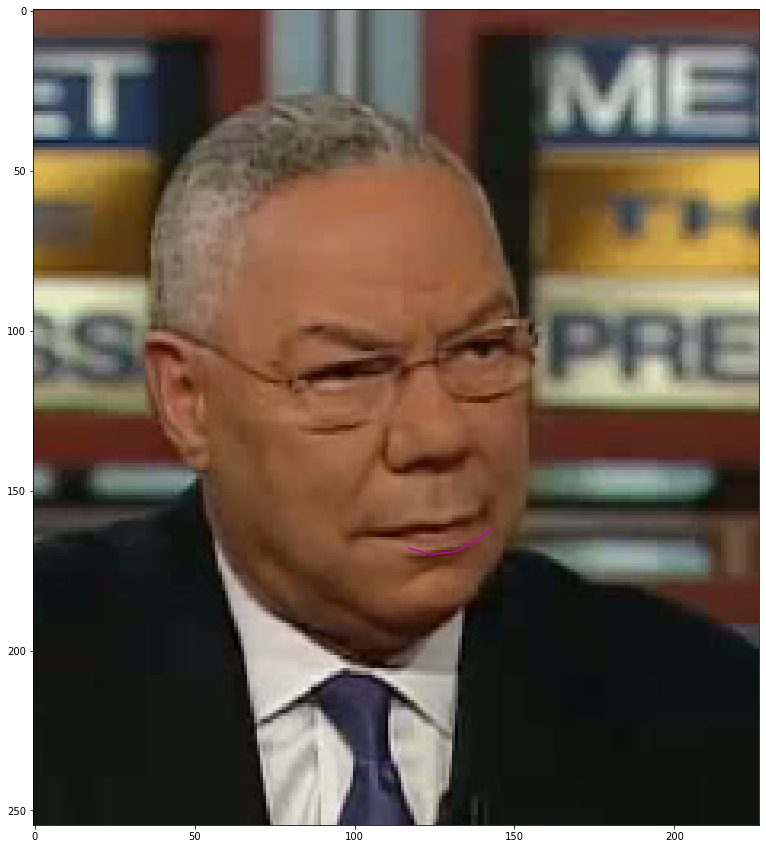

In [283]:
from scipy.optimize import curve_fit
from matplotlib import transforms

def func1(x, a, b, c): return a*x**2+b*x+c

image = mpimg.imread(os.path.join('data/training/', image_name))
image_gra = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
angle = getAngleImage(key_pts)

mouth = key_pts[54:60]
x, y = sorted(mouth[:, 0]), [a for _, a in sorted(zip(mouth[:, 0], mouth[:, 1]))]

popt, pcov = curve_fit(func1, x, y)

a, b, c = popt[0], popt[1], popt[2]
y_new = [int(func1(x1, a, b, c)) for x1 in x ]

"""Show image with keypoints"""
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

base = plt.gca().transData
rotation = transforms.Affine2D().rotate_deg(angle)
#ax.plot(x, y_new, c='m', transform = rotation + base)
ax.plot(x, y_new, c='m')

print(smiles)
for smile in smiles:
  #x, y, w, h = smile
  print(smile)
  #cv2.rectangle(image, (x,y),(x+w,y+h),(255,0,0),3) 

plt.imshow(image)

plt.show()
plt.clf()
plt.cla()
plt.close()

[117.0, 124.0, 132.0, 139.0, 143.0, 143.0] [168 170 169 165 162 162]
[117.         110.10806245 102.23156238  95.33962483  91.4013748
  91.4013748 ] [168.         168.35006667 168.17503333 167.4749     166.94979999
 166.94979999]
[[149 130  68  34]
 [ 82 145  68  34]]
[149 130  68  34]
[ 82 145  68  34]


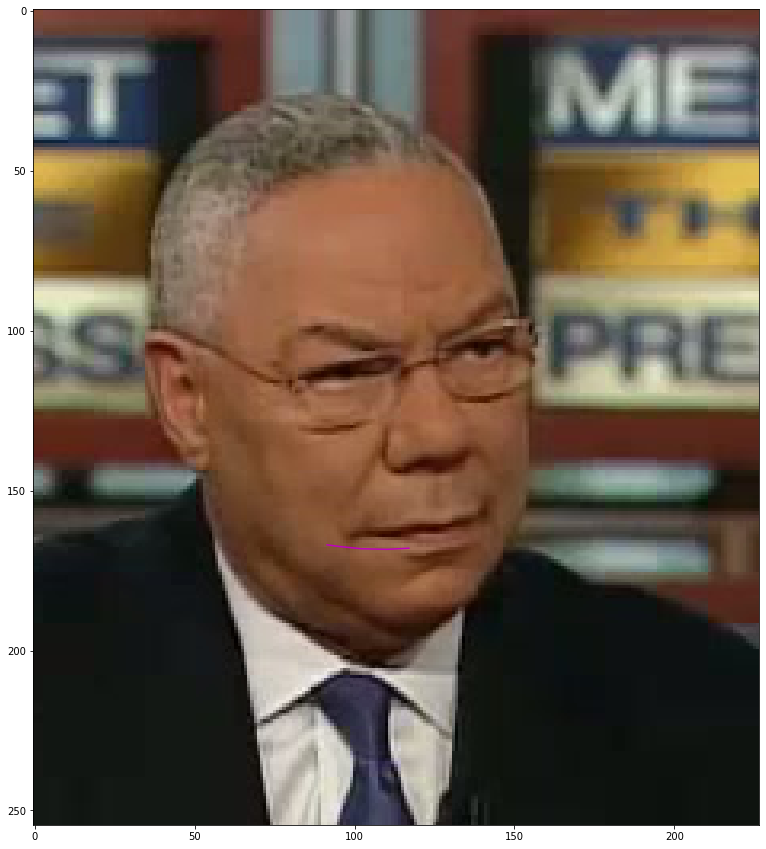

In [302]:
from scipy.optimize import curve_fit
from matplotlib import transforms
from math import pi, cos, sin

def func1(x, a, b, c): return a*x**2+b*x+c

image = mpimg.imread(os.path.join('data/training/', image_name))
image_gra = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
angle = getAngleImage(key_pts)

mouth = key_pts[54:60]
x, y = sorted(mouth[:, 0]), [a for _, a in sorted(zip(mouth[:, 0], mouth[:, 1]))]

popt, pcov = curve_fit(func1, x, y)

a, b, c = popt[0], popt[1], popt[2]
y_new = np.array([int(func1(x1, a, b, c)) for x1 in x ])

print(x, y_new)
x     = (x[0] - x)*cos(angle * pi / 180) + x[0]
y_new = (y_new[0] - y_new)*sin(angle * pi / 180) + y_new[0]
print(x, y_new)

"""Show image with keypoints"""
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

base = plt.gca().transData
ax.plot(x, y_new, c='m')

print(smiles)
for smile in smiles:
  #x, y, w, h = smile
  print(smile)
  #cv2.rectangle(image, (x,y),(x+w,y+h),(255,0,0),3) 

plt.imshow(image)

plt.show()
plt.clf()
plt.cla()
plt.close()

## Swap Faces

In [664]:
def faceMask(image, key_pts, e_sizeh=0, e_sizew=0):
    img_masked = np.copy(image)
    nose = key_pts[29,:]
    head = key_pts[0:16,:]
    if e_sizeh == 0 == e_sizew: h, w = (max(head[:,0]) - nose [0]) * 1.1, (max(head[:,1]) - nose [1]) * 1.1
    else: h, w  = e_sizeh, e_sizew
    
    center = (int(nose[0]), int(nose[1]))
    axes = (int(h) , int(w)) # first, second
    angle = 0 #getAngleImage(key_pts)
    color = (0, 177, 64) # green color in RGB

    img_masked=cv2.ellipse(img_masked, center , axes, angle, 0., 360, color , -1)
    
    return img_masked, h, w, center

In [665]:
def prepareImageSwap(n, e_sizeh=0, e_sizew=0):
  IMAGE_SIZE = 224

  image = cv2.imread(os.path.join('data/training/', key_pts_frame.iloc[n, 0]))
  scale = [IMAGE_SIZE / image.shape[1], IMAGE_SIZE / image.shape[0]]
  image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_CUBIC)
  key_pts = key_pts_frame.iloc[n, 1:].values.astype('float').reshape(-1, 2)
  key_pts *= scale
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_masked, h, w, center = faceMask(image, key_pts, e_sizeh, e_sizew)

  mask = cv2.inRange(image_masked, (0,177,64), (0,177,64))
  face_img = np.copy(image)
  face_img[mask == 0] = [0, 0, 0]

  return image, key_pts, mask, h, w, center

In [666]:
def swapTwoFaces(n1, n2):
  image1, key_pts1, mask1, h, w, center1 = prepareImageSwap(n1)
  image2, key_pts2, mask2, _, _, center2 = prepareImageSwap(n2, h, w)

  diffx, diffy = center1[0] - center2[0], center1[1] - center2[1]
  colx, coly = np.zeros((abs(diffx),face_img2.shape[1], 3)), np.zeros((face_img2.shape[0],abs(diffy), 3))

  if diffx > 0: face_img2_moved = np.vstack([colx, image2[:-diffx,:,:]])
  else:         face_img2_moved = np.vstack([image2[-diffx:,:,:], colx])
  if diffy > 0: face_img2_moved = np.hstack([coly, face_img2_moved[:,:-diffy,:]])
  else:         face_img2_moved = np.hstack([face_img2_moved[:,-diffy:,:], coly])

  diffx *= -1; diffy *= -1

  if diffx > 0: face_img1_moved = np.vstack([colx, image1[:-diffx,:,:]])
  else:         face_img1_moved = np.vstack([image1[-diffx:,:,:], colx])
  if diffy > 0: face_img1_moved = np.hstack([coly, face_img1_moved[:,:-diffy,:]])
  else:         face_img1_moved = np.hstack([face_img1_moved[:,-diffy:,:], coly])

  ind1 = np.argwhere(mask1 == 255)
  ind2 = np.argwhere(mask2 == 255)
  image_masked1 = np.copy(image1)
  image_masked2 = np.copy(image2)

  for i in range(3):
    image_masked1[ind1[:,0], ind1[:,1] ,i] = face_img2_moved[ind1[:,0],ind1[:,1],i]
    image_masked2[ind2[:,0], ind2[:,1] ,i] = face_img1_moved[ind2[:,0],ind2[:,1],i]

  return image_masked1, image_masked2


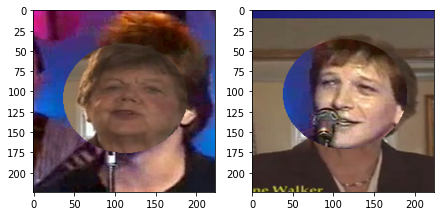

In [667]:
img1, img2 = swapTwoFaces(1615, 2488)

fig = plt.figure(figsize=(15, 15))
plt.subplot(241)
plt.imshow((img1).astype(np.uint8))
plt.subplot(242)
plt.imshow((img2).astype(np.uint8))

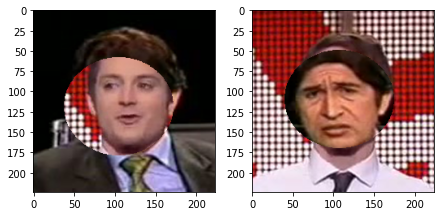

In [669]:
img1, img2 = swapTwoFaces(25, 248)

fig = plt.figure(figsize=(15, 15))
plt.subplot(241)
plt.imshow((img1).astype(np.uint8))
plt.subplot(242)
plt.imshow((img2).astype(np.uint8))

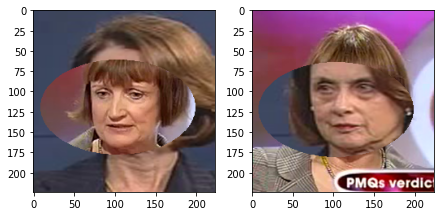

In [676]:
img1, img2 = swapTwoFaces(211, 338)

fig = plt.figure(figsize=(15, 15))
plt.subplot(241)
plt.imshow((img1).astype(np.uint8))
plt.subplot(242)
plt.imshow((img2).astype(np.uint8))

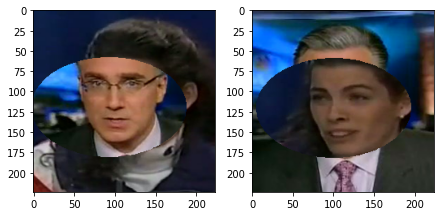

In [685]:
img1, img2 = swapTwoFaces(532, 849)

fig = plt.figure(figsize=(15, 15))
plt.subplot(241)
plt.imshow((img1).astype(np.uint8))
plt.subplot(242)
plt.imshow((img2).astype(np.uint8))